In [1]:
import nibabel as nib
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import zoom
from ipywidgets import interact, IntSlider

In [3]:
fixed_image = sitk.ReadImage(r"d:\Direct_CTP_Transform\CTH_stripped.nii")

In [14]:
def read_dicom_series(directory):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(directory)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()

    # If the image is multi-component (e.g., RGB), convert it to grayscale
    if image.GetNumberOfComponentsPerPixel() > 1:
        channels = [sitk.VectorIndexSelectionCast(image, i) for i in range(image.GetNumberOfComponentsPerPixel())]
        image = sum(channels) / len(channels)
    image = sitk.Cast(image, sitk.sitkFloat32)
    return image

moving_image_directory = r"D:\CTH_archive\TEST_TMAX"

moving_image = read_dicom_series(moving_image_directory)

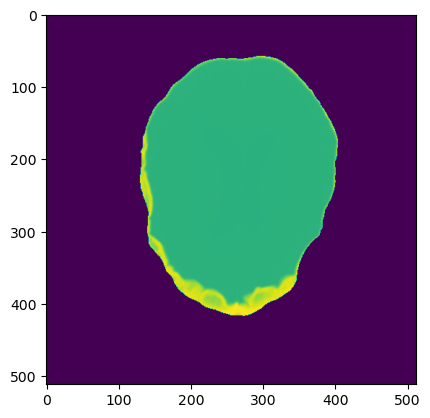

In [4]:
plt.imshow(sitk.GetArrayFromImage(fixed_image)[15,:,:])

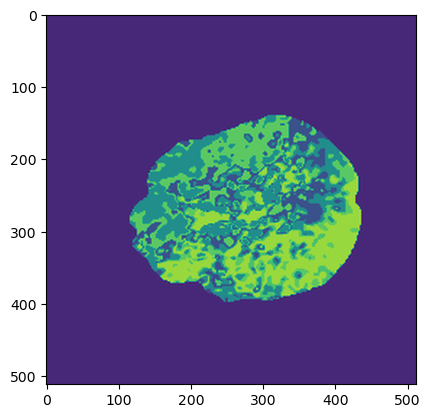

In [29]:
tmax_overlay_np = sitk.GetArrayFromImage(moving_image)

cropped_tmax_overlay_np = tmax_overlay_np[:, 30: , :] # crop out top 30 pixels to remove tmax
cropped_tmax_overlay_np.shape
cropped_tmax_overlay_np[: , : , :54] = 0 # Remove Tmax text

resized_slices = np.empty((cropped_tmax_overlay_np.shape[0], 512, 512), dtype=cropped_tmax_overlay_np.dtype)
for i in range(cropped_tmax_overlay_np.shape[0]):  # Loop through slices
        # Apply zoom to each channel of the slice
        resized_slices[i, :, :] = zoom(cropped_tmax_overlay_np[i, :, :], (512 / 256, 512 / 256))

resized_slices = np.transpose(resized_slices, (2, 1, 0))
plt.imshow(resized_slices[:,:,15])

In [30]:
affine = np.eye(4)
affine[1, 1] *= -1 #flip AP
CTP_resized_img = nib.Nifti1Image(resized_slices, affine)
nib.save(CTP_resized_img, r'D:\CTH_archive\CTP_resized.nii')